# Extract barrier island metrics along transects

Author: Emily Sturdivant, esturdivant@usgs.gov

***

Extract barrier island metrics along transects for Barrier Island Geomorphology Bayesian Network. See the project [README](https://github.com/esturdivant-usgs/BI-geomorph-extraction/blob/master/README.md) and the Methods Report (Zeigler et al., in review). 


## Pre-requisites:
- All the input layers (transects, shoreline, etc.) must be ready. This is performed with the notebook file prepper.ipynb.
- The files servars.py and configmap.py may need to be updated for the current dataset.

## Notes:
- This notebook includes interactive quality checking, which requires the user's attention. For thorough QC'ing, we recommend displaying the layers in ArcGIS, especially to confirm the integrity of values for variables such as distance to inlet (__Dist2Inlet__) and widths of the landmass (__WidthPart__, etc.). 


***

## Import modules

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import io
import arcpy
import pyproj
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import core.functions_warcpy as fwa
import core.functions as fun

print("Date: {}".format(datetime.date.today()))
# print(os.__version__)
# print(sys.__version__)
print('pandas version: {}'.format(pd.__version__))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(matplotlib.__version__))
# print(io.__version__)
# print(arcpy.__version__)
print('pyproj version: {}'.format(pyproj.__version__))

# print(bi_transect_extractor.__version__)

Date: 2019-10-10
pandas version: 0.20.3
numpy version: 1.13.1
matplotlib version: 1.5.3
pyproj version: 1.9.5.1


### Initialize variables

This cell prompts you for the site, year, and project directory path. `setvars.py` retrieves the pre-determined values for that site in that year from `configmap.py`. The project directory will be used to set up your workspace. It's hidden for security – sorry! I recommend that you type the path somewhere and paste it in.

In [2]:
from core.setvars import *

site (options: Smith, FireIsland, Wreck, Metompkin, Assateague, Myrtle, Assawoman, CoastGuard, Rockaway, Cedar, CapeHatteras, ShipShoal, Fisherman, Monomoy, Parramore, Cobb, CapeLookout, RhodeIsland, ParkerRiver, Forsythe):  RhodeIsland
year (options: 2010, 2012, 2014):  2014
Path to project directory (e.g. \\Macolume\dir\FireIsland2014):  ····················································


setvars.py initialized variables.
SITE: RhodeIsland
MHW: 0.29
MLW: -0.42
Max dune crest height: 2.5
Projection code: 26919



Change the filename variables to match your local files. They should be in an Esri file geodatabase named site+year.gdb in your project directory, which you input above and is the value of the variable `home`. 

In [3]:
# Extended transects: NASC transects extended and sorted, ready to be the base geometry for processing
extendedTrans = os.path.join(home, 'extTrans')

# Tidied transects: Extended transects without overlapping transects
extTrans_tidy = os.path.join(home, 'tidyTrans') 

# Geomorphology points: positions of indicated geomorphic features
ShorelinePts = os.path.join(home, 'SLpts')  # shoreline
dlPts = os.path.join(home, 'DLpts')         # dune toe
dhPts = os.path.join(home, 'DCpts')         # dune crest

# Inlet lines: polyline feature classes delimiting inlet position. Must intersect the full island shoreline
inletLines = os.path.join(home, 'inletLines')

# Full island shoreline: polygon that outlines the island shoreline, MHW on oceanside and MTL on bayside
barrierBoundary = os.path.join(home, 'bndpoly_2sl_utm19')  

# Elevation grid: DEM of island elevation at either 5 m or 1 m resolution
elevGrid = os.path.join(home, 'dem_download_merged_5m')

# ---
# OPTIONAL - comment out each one that is not available
# ---

# Study area boundary; manually digitize if the barrier island study area does not end at an inlet.
SA_bounds = os.path.join(home, 'SA_bounds')

# Armoring lines: digitize lines of shorefront armoring to be used if dune toe points are not available.
armorLines = os.path.join(home, 'armorLines')

# # Extended transects with Construction, Development, and Nourishment coding
# tr_w_anthro = os.path.join(home, 'extTrans_widthsmask_wAnthro')
extTrans_mask = os.path.join(home, 'extTrans_widthsmask')

# # Piping Plover Habitat BN raster layers
SubType = os.path.join(home, 'SubType')   # substrate type
VegType = os.path.join(home, 'VegType')   # vegetation type
VegDens = os.path.join(home, 'VegDens')    # vegetation density
GeoSet = os.path.join(home, 'GeoSet')     # geomorphic setting

# Derivatives of inputs: They will be generated during process if they are not found. 
shoreline = os.path.join(home, 'ShoreBetweenInlets')   # oceanside shoreline between inlets; generated from shoreline polygon, inlet lines, and SA bounds
slopeGrid = os.path.join(home, 'slope_5m')   # Slope at 5 m resolution; generated from DEM

### Split features between MHW zones - mhw29, mhw22, mhw36

In [4]:
# mhw29
extendedTrans_mhw29 = os.path.join(home, 'extTrans_mhw29')
ShorelinePts_mhw29 = os.path.join(home, 'SLpts_mhw29')
dlPts_mhw29 = os.path.join(home, 'DTpts_mhw29')
dhPts_mhw29 = os.path.join(home, 'DCpts_mhw29')
armorLines_mhw29 = os.path.join(home, 'armorLines_mhw29')
# shoreline_west = os.path.join(home, 'ShoreBetweenInlets_mhw29')

# mhw22
extendedTrans_mhw22 = os.path.join(home, 'extTrans_mhw22')
ShorelinePts_mhw22 = os.path.join(home, 'SLpts_mhw22')
dlPts_mhw22 = os.path.join(home, 'DTpts_mhw22')
dhPts_mhw22 = os.path.join(home, 'DCpts_mhw22')
armorLines_mhw22 = os.path.join(home, 'armorLines_mhw22')
# shoreline_mhw22 = os.path.join(home, 'ShoreBetweenInlets_mhw22')

# mhw36
extendedTrans_mhw36 = os.path.join(home, 'extTrans_mhw36')
ShorelinePts_mhw36 = os.path.join(home, 'SLpts_mhw36')
dlPts_mhw36 = os.path.join(home, 'DTpts_mhw36')
dhPts_mhw36 = os.path.join(home, 'DCpts_mhw36')
armorLines_mhw36 = os.path.join(home, 'armorLines_mhw36')
# shoreline_mhw36 = os.path.join(home, 'ShoreBetweenInlets_mhw36')

## Transect-averaged values
We work with the shapefile/feature class as a pandas DataFrame as much as possible to speed processing and minimize reliance on the ArcGIS GUI display.

1. Create a pandas dataframe from the transects feature class. In the process, we remove some of the unnecessary fields. The resulting dataframe is indexed by __sort_ID__ with columns corresponding to the attribute fields in the transects feature class. 
2. Add __DD_ID__.
3. Join the values from the transect file that includes the three anthropologic development fields, __Construction__,  __Development__, and __Nourishment__. 

In [17]:
# Add BEARING field to extendedTrans feature class
print("Adding line bearing field to transects.")
arcpy.AddGeometryAttributes_management (extendedTrans, 'LINE_BEARING')

# Copy feature class to dataframe.
trans_df = fwa.FCtoDF(extendedTrans, id_fld=tID_fld, extra_fields=extra_fields)

# Set capitalization of fields to match expected
colrename = {}
for f in sorted_pt_flds:
    for c in trans_df.columns:
        if f.lower() == c.lower() and f != c:
            colrename[c] = f
            print("Renaming {} to {}".format(c, f))
trans_df.rename(columns=colrename, inplace=True)

# Set DD_ID, MHW, and Azimuth fields
trans_df['DD_ID'] = trans_df[tID_fld] + sitevals['id_init_val']
# trans_df['MHW'] = sitevals['MHW']
trans_df.drop('Azimuth', axis=1, inplace=True, errors='ignore')
trans_df.rename_axis({"BEARING": "Azimuth"}, axis=1, inplace=True)

# Get anthro fields and join to DF
if 'tr_w_anthro' in locals():
    trdf_anthro = fwa.FCtoDF(tr_w_anthro, id_fld=tID_fld, dffields=['Development', 'Nourishment','Construction'])
    trans_df = fun.join_columns(trans_df, trdf_anthro) 

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

# Display
print("\nHeader of transects dataframe (rows 1-5 out of {}): ".format(len(trans_df)))
trans_df.head()
trans_df.loc[:,['sort_ID', 'DD_ID', 'TRANSECTID', 'LRR', 'MHW', 'Development', 'Nourishment', 'Construction']].sample(10)

Adding line bearing field to transects.
...converting feature class to array...
...converting array to dataframe...
Renaming TransectId to TRANSECTID

Header of transects dataframe (rows 1-5 out of 824): 


,sort_ID,DD_ID,TRANSECTID,LRR,MHW,Development,Nourishment,Construction
sort_ID,,,,,,,,
278,278,50278,273.0,-0.11,NaN,NaN,NaN,NaN
74,74,50074,71.0,-0.31,NaN,NaN,NaN,NaN
303,303,50303,298.0,-0.45,NaN,NaN,NaN,NaN
704,704,50704,698.0,0.05,NaN,NaN,NaN,NaN
184,184,50184,181.0,-0.09,NaN,NaN,NaN,NaN
667,667,50667,659.0,0.21,NaN,NaN,NaN,NaN
439,439,50439,433.0,-0.29,NaN,NaN,NaN,NaN
277,277,50277,272.0,-0.07,NaN,NaN,NaN,NaN
13,13,50013,13.0,-0.87,NaN,NaN,NaN,NaN


In [18]:
trans_df['Development'] = 111

# Rhode Island values for Development at each transect
devnone = {262:311, 376:458, 505:513, 540:573, 576:585, 641:647} # 111 # none
for st, en in devnone.items():
    trans_df.loc[st:en+1, ['Development']] = 111
devlight = {112:137, 157:178, 312:312, 316:329, 346:349, 354:356, 362:375, 459:496, 514:524, 538:539, 574:576, 586:594, 605:612, 621:624, 638:640, 648:661, 678:694, 712:712} # 222 # light
for st, en in devlight.items():
    trans_df.loc[st:en+1, ['Development']] = 222
devmod = {47:111, 138:157, 230:261, 313:315, 330:345, 350:353, 357:361, 525:529, 531:537, 595:604, 613:620, 624:637, 662:677, 695:711, 713:824} # 333 # moderate
for st, en in devmod.items():
    trans_df.loc[st:en+1, ['Development']] = 333

# Construction
trans_df['Construction'] = 111
consoft = {326:339, 345:359, 362:365, 459:506, 514:515, 520:521, 524:527, 532:532, 536:537, 586:589, 597:599, 602:603, 609:610, 613:614, 623:624, 631:632, 648:656, 671:674, 691:698, 726:756, 759:785, 796:810} # 222
for st, en in consoft.items():
    trans_df.loc[st:en+1, ['Construction']] = 222
conhard = {44:44, 56:60, 64:72, 136:136, 236:236, 312:313, 459:459, 533:535, 614:619, 622:622, 627:627, 623:623, 635:640, 671:672, 692:692, 695:695, 698:698, 700:700, 703:703, 720:721, 820:824} # 333
for st, en in conhard.items():
    trans_df.loc[st:en+1, ['Construction']] = 333

# Nourishment
trans_df['Nourishment'] = 333
occasional = {52:55, 115:132, 137:140, 145:159, 160:181, 184:184, 187:191, 198:198, 200:200, 204:204, 231:235, 236:239, 472:473, 484:484, 488:496, 502:507, 516:517, 523:524, 536:537, 589:589, 603:603, 606:614, 618:618, 622:622, 626:629, 671:702, 707:708, 743:743}
for st, en in occasional.items():
    trans_df.loc[st:en+1, ['Nourishment']] = 111
frequent = {726:740}
for st, en in frequent.items():
    trans_df.loc[st:en+1, ['Nourishment']] = 222

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))
trans_df.loc[:,['sort_ID', 'DD_ID', 'TRANSECTID', 'LRR', 'MHW', 'Development', 'Nourishment', 'Construction']].sample(10)

,sort_ID,DD_ID,TRANSECTID,LRR,MHW,Development,Nourishment,Construction
sort_ID,,,,,,,,
686,686,50686,681.0,0.32,NaN,222,111,111
370,370,50370,364.0,-0.37,NaN,222,333,111
372,372,50372,366.0,-0.36,NaN,222,333,111
475,475,50475,470.0,-0.35,NaN,222,333,222
573,573,50573,568.0,-0.16,NaN,111,333,111
83,83,50083,80.0,-0.33,NaN,333,333,111
459,459,50459,454.0,-0.11,NaN,222,333,333
29,29,50029,29.0,-0.83,NaN,111,333,111
784,784,50784,NaN,NaN,NaN,333,333,222


In [19]:
# Sort by ID before selecting by index
trans_df = trans_df.sort_values(by=tID_fld)

# Select transects with MHW 0.29
trans_df.loc[:117, 'MHW'] = 0.29
trans_mhw29 = trans_df.loc[:117, :]
trans_mhw29.to_pickle(os.path.join(scratch_dir, 'trans_mhw29.pkl'))

# Select transects with MHW 0.22
trans_df.loc[118:725, 'MHW'] = 0.22
trans_mhw22 = trans_df.loc[118:725, :]
trans_mhw22.to_pickle(os.path.join(scratch_dir, 'trans_mhw22.pkl'))

# Select transects with MHW 0.36
trans_df.loc[726:, 'MHW'] = 0.36
trans_mhw36 = trans_df.loc[726:, :]
trans_mhw36.to_pickle(os.path.join(scratch_dir, 'trans_mhw36.pkl'))

# Save
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))

In [20]:
# Read original
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))
trans_mhw29 = pd.read_pickle(os.path.join(scratch_dir, 'trans_mhw29.pkl'))
trans_mhw22 = pd.read_pickle(os.path.join(scratch_dir, 'trans_mhw22.pkl'))
trans_mhw36 = pd.read_pickle(os.path.join(scratch_dir, 'trans_mhw36.pkl'))
print("Length of trans_df: ", len(trans_df))
print("Length of trans_mhw29: ", len(trans_mhw29))
print("Length of trans_mhw22: ", len(trans_mhw22))
print("Length of trans_mhw36: ", len(trans_mhw36), "|  Index range: ", trans_mhw36.index.min(), trans_mhw36.index.max())

trans_df.loc[:,['sort_ID', 'DD_ID', 'TRANSECTID', 'LRR', 'MHW', 'Development', 'Nourishment', 'Construction']].sample(10)

Length of trans_df:  824
Length of trans_mhw29:  117
Length of trans_mhw22:  608
Length of trans_mhw36:  99 |  Index range:  726 824


,sort_ID,DD_ID,TRANSECTID,LRR,MHW,Development,Nourishment,Construction
sort_ID,,,,,,,,
376,376,50376,370.0,-0.29,0.22,222,333,111
351,351,50351,346.0,-0.17,0.22,333,333,222
260,260,50260,255.0,-0.19,0.22,333,333,111
542,542,50542,537.0,0.01,0.22,111,333,111
252,252,50252,247.0,-0.16,0.22,333,333,111
544,544,50544,539.0,-0.02,0.22,111,333,111
659,659,50659,1849.0,-0.06,0.22,222,333,111
806,806,50806,NaN,NaN,0.36,333,333,222
227,227,50227,224.0,0.00,0.22,111,333,111


### Get XY and Z/slope from SL, DH, DL points within 25 m of transects
Add to each transect row the positions of the nearest pre-created beach geomorphic features (shoreline, dune toe, and dune crest).

#### If needed, convert morphology points stored locally to feature classes for use.
After which, view the new feature classes in a GIS. Isolate the points to the region of interest. Quality check them. Then copy them for use with this code, which will require setting the filenames to match those included here or changing the values included here to match the final filenames.

In [16]:
if "morphdata_prefix" in locals():
    csvpath = os.path.join(proj_dir, 'Input_Data', '{}_morphology'.format(morphdata_prefix), 
                           '{}_morphology.csv'.format(morphdata_prefix))
    dt_fc, dc_fc, sl_fc = fwa.MorphologyCSV_to_FCsByFeature(csvpath, state, proj_code, 
                                                            csv_fill = 999, fc_fill = -99999, csv_epsg=4326)
    print("OUTPUT: morphology point feature classes in the scratch gdb. We recommend QC before proceeding.")

In [11]:
if not arcpy.Exists(shoreline):
    if not 'SA_bounds' in locals(): 
        SA_bounds = ''
shoreline = fwa.CreateShoreBetweenInlets(barrierBoundary, inletLines, shoreline, ShorelinePts, proj_code, SA_bounds)

Splitting bndpoly_2sl_utm19 at inlets and study area bounds...
Preserving only those line segments that intersect shoreline points...
Dissolving the line to create ShoreBetweenInlets...


#### Shoreline

The MHW shoreline easting and northing (__SL_x__, __SL_y__) are the coordinates of the intersection of the oceanside shoreline with the transect. Each transect is assigned the foreshore slope (__Bslope__) from the nearest shoreline point within 25 m. These values are populated for each transect as follows: 
1. get __SL_x__ and __SL_y__ at the point where the transect crosses the oceanside shoreline; 
2. find the closest shoreline point to the intersection point (must be within 25 m) and copy the slope value from the point to the transect in the field __Bslope__.

In [19]:
#%% Shoreline
# mhw29: Get the XY position where transect crosses the oceanside shoreline
sl2trans_mhw29, ShorelinePts_mhw29 = fwa.add_shorelinePts2Trans(extendedTrans_mhw29, ShorelinePts_mhw29, shoreline, 
                                            tID_fld, proximity=pt2trans_disttolerance)
sl2trans_mhw29.to_pickle(os.path.join(scratch_dir, 'sl2trans_mhw29.pkl'))


# mhw29: Get the XY position where transect crosses the oceanside shoreline
sl2trans_mhw22, ShorelinePts_mhw22 = fwa.add_shorelinePts2Trans(extendedTrans_mhw22, ShorelinePts_mhw22, shoreline, 
                                            tID_fld, proximity=pt2trans_disttolerance)
sl2trans_mhw22.to_pickle(os.path.join(scratch_dir, 'sl2trans_mhw22.pkl'))


# mhw36: Get the XY position where transect crosses the oceanside shoreline
sl2trans_mhw36, ShorelinePts_mhw36 = fwa.add_shorelinePts2Trans(extendedTrans_mhw36, ShorelinePts_mhw36, shoreline,
                                            tID_fld, proximity=pt2trans_disttolerance)
sl2trans_mhw36.to_pickle(os.path.join(scratch_dir, 'sl2trans_mhw36.pkl'))


Matching shoreline points to transects...
Using field 'slope' as slope.
The projection of SLpts_mhw29 was changed. The new file is SLpts_mhw29_utm.
...duration at transect 100: 0:0:33.5 seconds
Duration: 0:0:38.3 seconds

Matching shoreline points to transects...
Using field 'slope' as slope.
The projection of SLpts_mhw22 was changed. The new file is SLpts_mhw22_utm.
...duration at transect 200: 0:0:44.3 seconds
...duration at transect 300: 0:1:30.3 seconds
...duration at transect 400: 0:2:16.6 seconds
...duration at transect 500: 0:3:4.9 seconds
...duration at transect 600: 0:3:54.0 seconds
...duration at transect 700: 0:4:45.0 seconds
Duration: 0:4:57.6 seconds

Matching shoreline points to transects...
Using field 'slope' as slope.
The projection of SLpts_mhw36 was changed. The new file is SLpts_mhw36_utm.
...duration at transect 800: 0:0:28.1 seconds
Duration: 0:0:35.0 seconds


In [14]:
arcpy.Merge_management([ShorelinePts_mhw29, ShorelinePts_mhw22, ShorelinePts_mhw36], ShorelinePts+'_merged')
csv_fname = fwa.pts_to_csv_and_eainfoxml(ShorelinePts+'_merged', '_SLpts', scratch_dir, pts_name, field_defs, fill)

...converting feature class to array...
...converting array to dataframe...
Number of points in dataset: (3722, 11)

OBJECTID_______________________________1 | 3722________________   No fills_________No nulls
Shape............... nan
state............... 17  |  18
seg____________________________________1 | 64__________________   No fills_________No nulls
profile________________________________1 | 454_________________   No fills_________No nulls
sl_x___________________________-88.13618 | 945.8687____________   No fills_________No nulls
ci95_slx___________________________5e-05 | 1.017426____________   No fills_________No nulls
slope___________________________-0.14017 | -0.0018536__________   No fills_________No nulls
easting____________________258347.549131 | 312862.872142_______   No fills_________No nulls
northing__________________4576706.949534 | 4595535.635709______   No fills_________No nulls
MHW_________________________________0.22 | 0.36________________   No fills_________No nulls

#### Dune positions along transects

__DL_x__, __DL_y__, and __DL_z__ are the easting, northing, and elevation, respectively, of the nearest dune toe point within 25 meters of the transect. __DH_x__, __DH_y__, and __DH_z__ are the easting, northing, and elevation, respectively, of the nearest dune crest point within 25 meters. 

__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__ are the eastings and northings of the points "snapped" to the transect. "Snapping" finds the position along the transect nearest to the point, i.e. orthogonal to the transect. These values are used to find the beach width. The elevation values are not snapped; we use the elevation values straight from the original points. 

These values are populated as follows: 

1. Find the nearest dune crest/toe point to the transect and proceed if the distance is less than 25 m. If there are no points within 25 m of the transect, populate the row with Null values.
2. Get the X, Y, and Z values of the point. 
3. Find the position along the transect of an orthogonal line drawn to the dune point (__DL_snapX__, __DL_snapY__, __DH_snapX__, and __DH_snapY__). This is considered the 'snapped' XY position and is calculated using the arcpy geometry method. 

In [11]:
# mhw29: Create dataframe for both dune crest and dune toe positions
dune2trans_mhw29 = fwa.find_ClosestPt2Trans_snap(extendedTrans_mhw29, dhPts_mhw29, dlPts_mhw29, trans_mhw29, 
                                          tID_fld, proximity=pt2trans_disttolerance)
dune2trans_mhw29.to_pickle(os.path.join(scratch_dir, 'dune2trans_mhw29.pkl'))

# mhw22: Create dataframe for both dune crest and dune toe positions
dune2trans_mhw22 = fwa.find_ClosestPt2Trans_snap(extendedTrans_mhw22, dhPts_mhw22, dlPts_mhw22, trans_mhw22, 
                                          tID_fld, proximity=pt2trans_disttolerance)
dune2trans_mhw22.to_pickle(os.path.join(scratch_dir, 'dune2trans_mhw22.pkl'))

# mhw36: Create dataframe for both dune crest and dune toe positions
dune2trans_mhw36 = fwa.find_ClosestPt2Trans_snap(extendedTrans_mhw36, dhPts_mhw36, dlPts_mhw36, trans_mhw36, 
                                          tID_fld, proximity=pt2trans_disttolerance)
dune2trans_mhw36.to_pickle(os.path.join(scratch_dir, 'dune2trans_mhw36.pkl'))


Matching dune points with transects:
Using field 'dhigh_z' as DH Z field...
The projection of DCpts_mhw29 was changed. The new file is DCpts_mhw29_utm.
Using field 'dlow_z' as DL Z field...
The projection of DTpts_mhw29 was changed. The new file is DTpts_mhw29_utm.
Looping through transects and dune points to find nearest point within 25 m...
...duration at transect 100: 0:0:50.9 seconds
Duration: 0:0:56.2 seconds

Matching dune points with transects:
Using field 'dhigh_z' as DH Z field...
The projection of DCpts_mhw22 was changed. The new file is DCpts_mhw22_utm.
Using field 'dlow_z' as DL Z field...
The projection of DTpts_mhw22 was changed. The new file is DTpts_mhw22_utm.
Looping through transects and dune points to find nearest point within 25 m...
...duration at transect 200: 0:1:12.5 seconds
...duration at transect 300: 0:2:19.5 seconds
...duration at transect 400: 0:3:37.7 seconds
...duration at transect 500: 0:4:49.5 seconds
...duration at transect 600: 0:5:56.4 seconds
...du

In [15]:
arcpy.Merge_management([dlPts_mhw29, dlPts_mhw22, dlPts_mhw36], dlPts+'_merged')
csv_fname = fwa.pts_to_csv_and_eainfoxml(dlPts+'_merged', '_DTpts', scratch_dir, pts_name, field_defs, fill)

arcpy.Merge_management([dhPts_mhw29, dhPts_mhw22, dhPts_mhw36], dhPts+'_merged')
csv_fname = fwa.pts_to_csv_and_eainfoxml(dhPts+'_merged', '_DCpts', scratch_dir, pts_name, field_defs, fill)

...converting feature class to array...
...converting array to dataframe...
Number of points in dataset: (2716, 12)

OBJECTID_______________________________1 | 2716________________   No fills_________No nulls
Shape............... nan
state............... 17  |  18
seg____________________________________1 | 64__________________   No fills_________No nulls
profile________________________________1 | 452_________________   No fills_________No nulls
lon_____________________________-71.8864 | -71.2453____________   No fills_________No nulls
lat____________________________41.306067 | 41.489515___________   No fills_________No nulls
easting____________________258368.401739 | 312535.77094________   No fills_________No nulls
northing___________________4576748.49487 | 4595590.30285_______   No fills_________No nulls
dlow_x________________________-141.94166 | 67.05814____________   No fills_________No nulls
dlow_z__________________________1.061437 | 4.717208____________   No fills_________No nulls

#### Armoring
__Arm_x__, __Arm_y__, and __Arm_z__ are the easting, northing, and elevation, respectively, where an artificial structure crosses the transect in the vicinity of the beach. These features are meant to supplement the dune toe data set by providing an upper limit to the beach in areas where dune toe extraction was confounded by the presence of an artificial structure. Values are populated for each transect as follows: 

1. Get the positions of intersection between the digitized armoring lines and the transects (Intersect tool from the Overlay toolset); 
2. Extract the elevation value at each intersection point from the DEM (Extract Multi Values to Points tool from Spatial Analyst); 

In [74]:
# Create elevation raster at 5-m resolution if not already
# elevGrid = os.path.join(home, 'dem_USGS1314_bilinear5m_5m')
# elevGrid = fwa.ProcessDEM(elevGrid, utmSR)

# mhw29
arm2trans_mhw29 = fwa.ArmorLineToTrans_PD(extendedTrans_mhw29, armorLines_mhw29, sl2trans_mhw29, tID_fld, proj_code, elevGrid)
arm2trans_mhw29.to_pickle(os.path.join(scratch_dir, 'arm2trans_mhw29.pkl'))
print('arm2trans_mhw29 range: {} - {}'.format(arm2trans_mhw29.index.min(), arm2trans_mhw29.index.max()))
print('Trans 0.29: ', trans_mhw29.index.min(), trans_mhw29.index.max())
print('Completed processing for MHW 0.29')

Converting feature class to array with X and Y...
...converting array to dataframe...
Looks like these transects [60] are intersected by armoring lines multiple times. We will select the more seaward of the points.
arm2trans_mhw29 range: 56 - 76
Completed processing for MHW 0.29


<Result 'true'>

In [23]:
# mhw22
arm2trans_mhw22 = fwa.ArmorLineToTrans_PD(extendedTrans_mhw22, armorLines_mhw22, sl2trans_mhw22, tID_fld, proj_code, elevGrid)
arm2trans_mhw22.to_pickle(os.path.join(scratch_dir, 'arm2trans_mhw22.pkl'))
print('Completed processing for MHW 0.22')

Getting elevation of beach armoring by extracting elevation values to arm2trans points...
...MultipartToSinglepart_management...
...ExtractMultiValuesToPoints...
...FCtoDF...
Converting feature class to array with X and Y...
...converting array to dataframe...
Completed processing for MHW 0.22


In [24]:
print('arm2trans_mhw22 range: {} - {}'.format(arm2trans_mhw22.index.min(), arm2trans_mhw22.index.max()))
print('Trans 0.22: ', trans_mhw22.index.min(), trans_mhw22.index.max())

arm2trans_mhw22 range: 136 - 719
Trans 0.22:  118 725


In [78]:
# mhw36
arm2trans_mhw36 = fwa.ArmorLineToTrans_PD(extendedTrans_mhw36, armorLines_mhw36, sl2trans_mhw36, tID_fld, proj_code, elevGrid)
arm2trans_mhw36.to_pickle(os.path.join(scratch_dir, 'arm2trans_mhw36.pkl'))
print('Completed processing for MHW 0.36')
print('arm2trans_mhw36 range: {} - {}'.format(arm2trans_mhw36.index.min(), arm2trans_mhw36.index.max()))
print('Trans 0.36: ', trans_mhw36.index.min(), trans_mhw36.index.max())

Getting elevation of beach armoring by extracting elevation values to arm2trans points.
Converting feature class to array with X and Y...
...converting array to dataframe...
arm2trans_mhw36 range: 726 - 763
Trans 0.36:  726 824
Completed processing for MHW 0.36


<Result 'true'>

### Add all the positions to the trans_df
Join the new dataframes to the transect dataframe. Before it performs the join, `join_columns_id_check()` checks the index and the ID field for potential errors such as whether they are the equal and whether there are duplicated IDs or null values in either.

In [21]:
# Load saved dataframes
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df.pkl'))
trans_mhw29 = pd.read_pickle(os.path.join(scratch_dir, 'trans_mhw29.pkl'))
trans_mhw22 = pd.read_pickle(os.path.join(scratch_dir, 'trans_mhw22.pkl'))
trans_mhw36 = pd.read_pickle(os.path.join(scratch_dir, 'trans_mhw36.pkl'))

sl2trans_mhw29 = pd.read_pickle(os.path.join(scratch_dir, 'sl2trans_mhw29.pkl'))
sl2trans_mhw22 = pd.read_pickle(os.path.join(scratch_dir, 'sl2trans_mhw22.pkl'))
sl2trans_mhw36 = pd.read_pickle(os.path.join(scratch_dir, 'sl2trans_mhw36.pkl'))

dune2trans_mhw29 = pd.read_pickle(os.path.join(scratch_dir, 'dune2trans_mhw29.pkl'))
dune2trans_mhw22 = pd.read_pickle(os.path.join(scratch_dir, 'dune2trans_mhw22.pkl'))
dune2trans_mhw36 = pd.read_pickle(os.path.join(scratch_dir, 'dune2trans_mhw36.pkl'))

arm2trans_mhw29 = pd.read_pickle(os.path.join(scratch_dir, 'arm2trans_mhw29.pkl'))
arm2trans_mhw22 = pd.read_pickle(os.path.join(scratch_dir, 'arm2trans_mhw22.pkl'))
arm2trans_mhw36 = pd.read_pickle(os.path.join(scratch_dir, 'arm2trans_mhw36.pkl'))

In [22]:
fun.check_id_fld(trans_mhw29, tID_fld, fill=fill)
fun.check_id_fld(trans_mhw22, tID_fld, fill=fill)
fun.check_id_fld(trans_mhw36, tID_fld, fill=fill)

True

In [23]:
# West: Join positions of shoreline, dune crest, dune toe, armoring
trans_mhw29 = fun.join_columns_id_check(trans_mhw29, sl2trans_mhw29, tID_fld)
trans_mhw29 = fun.join_columns_id_check(trans_mhw29, dune2trans_mhw29, tID_fld)
trans_mhw29 = fun.join_columns_id_check(trans_mhw29, arm2trans_mhw29, tID_fld)
# Save
trans_mhw29.to_pickle(os.path.join(scratch_dir, 'trans_mhw29_beachmetrics.pkl'))
fun.check_id_fld(trans_mhw29, tID_fld, fill=fill)
print('Trans 0.29: ', trans_mhw29.index.min(), trans_mhw29.index.max())

# East: Join positions of shoreline, dune crest, dune toe, armoring
trans_mhw22 = fun.join_columns_id_check(trans_mhw22, sl2trans_mhw22, tID_fld)
trans_mhw22 = fun.join_columns_id_check(trans_mhw22, dune2trans_mhw22, tID_fld)
trans_mhw22 = fun.join_columns_id_check(trans_mhw22, arm2trans_mhw22, tID_fld)
# Save
trans_mhw22.to_pickle(os.path.join(scratch_dir, 'trans_mhw22_beachmetrics.pkl'))
fun.check_id_fld(trans_mhw22, tID_fld, fill=fill)
print('Trans 0.22: ', trans_mhw22.index.min(), trans_mhw22.index.max())

# East: Join positions of shoreline, dune crest, dune toe, armoring
trans_mhw36 = fun.join_columns_id_check(trans_mhw36, sl2trans_mhw36, tID_fld)
trans_mhw36 = fun.join_columns_id_check(trans_mhw36, dune2trans_mhw36, tID_fld)
trans_mhw36 = fun.join_columns_id_check(trans_mhw36, arm2trans_mhw36, tID_fld)
# Save
trans_mhw36.to_pickle(os.path.join(scratch_dir, 'trans_mhw36_beachmetrics.pkl'))
df = fun.check_id_fld(trans_mhw36, tID_fld, fill=fill)
print('Trans 0.36: ', trans_mhw36.index.min(), trans_mhw36.index.max())

...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
Trans 0.29:  1 117
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
Trans 0.22:  118 725
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
Trans 0.36:  726 824


In [24]:
# Concatenate the transect dataframes
trans_all_df = pd.concat([trans_mhw29, trans_mhw22, trans_mhw36])
trans_all_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics_concat.pkl'))
fun.check_id_fld(trans_all_df, tID_fld, fill=fill)

# Concatenate the morphology dataframes to store
sl2trans_df = pd.concat([sl2trans_mhw29, sl2trans_mhw22, sl2trans_mhw36])
sl2trans_df.to_pickle(os.path.join(scratch_dir, 'sl2trans_concat.pkl'))
df = fun.check_id_fld(sl2trans_df, tID_fld, fill=fill)

dune2trans_df = pd.concat([dune2trans_mhw29, dune2trans_mhw22, dune2trans_mhw36])
dune2trans_df.to_pickle(os.path.join(scratch_dir, 'dune2trans_concat.pkl'))
df = fun.check_id_fld(dune2trans_df, tID_fld, fill=fill)

arm2trans_df = pd.concat([arm2trans_mhw29, arm2trans_mhw22, arm2trans_mhw36])
arm2trans_df.to_pickle(os.path.join(scratch_dir, 'arm2trans_df_concat.pkl'))
df = fun.check_id_fld(arm2trans_df, tID_fld, fill=fill)

In [25]:
trans_df = trans_all_df

# QC: 
fun.check_id_fld(trans_df, tID_fld, fill=fill)

True

In [26]:
trans_df = trans_df.astype({'Arm_z':'float64'})

### Check for errors
*Optional*

Display summary stats / histograms and create feature classes. The feature classes display the locations that will be used to calculate beach width. Review the output feature classes in a GIS to validate. 

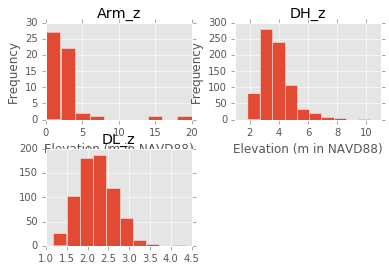

In [27]:
plots = trans_df.hist(['DH_z', 'DL_z', 'Arm_z'])

# Subplot Labels
plots[0][0].set_xlabel("Elevation (m in NAVD88)")
plots[0][0].set_ylabel("Frequency")
plots[0][1].set_xlabel("Elevation (m in NAVD88)")
plots[0][1].set_ylabel("Frequency")
try:
    plots[0][2].set_xlabel("Elevation (m in NAVD88)")
    plots[0][2].set_ylabel("Frequency")
except:
    pass

plt.show()
plt.close()

In [28]:
# Convert dataframe to feature class - shoreline points with slope
fwa.DFtoFC(sl2trans_df, os.path.join(arcpy.env.workspace, 'pts2trans_SL'), 
           spatial_ref=utmSR, id_fld=tID_fld, xy=["SL_x", "SL_y"], keep_fields=['Bslope'])
print('OUTPUT: pts2trans_SL in designated scratch geodatabase.\n')

# Dune crests
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.workspace, 'ptSnap2trans_DH'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DH_snapX", "DH_snapY"], keep_fields=['DH_z'])
    print('OUTPUT: ptSnap2trans_DH in designated scratch geodatabase.\n')
except Exception as err:
    print(err)
    pass

# Dune toes
try:
    fwa.DFtoFC(dune2trans_df, os.path.join(arcpy.env.workspace, 'ptSnap2trans_DL'), 
               spatial_ref=utmSR, id_fld=tID_fld, xy=["DL_snapX", "DL_snapY"], keep_fields=['DL_z'])
    print('OUTPUT: ptSnap2trans_DL in designated scratch geodatabase.\n')
except Exception as err:
    print(err)
    pass

... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: pts2trans_SL in designated scratch geodatabase.

... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: ptSnap2trans_DH in designated scratch geodatabase.

... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: ptSnap2trans_DL in designated scratch geodatabase.



### Calculate upper beach width and height
Upper beach width (__uBW__) and upper beach height (__uBH__) are calculated based on the difference in position between two points: the position of MHW along the transect (__SL_x__, __SL_y__) and the dune toe position or equivalent (usually __DL_snapX__, __DL_snapY__).  In some cases, the dune toe is not appropriate to designate the "top of beach" so beach width and height are calculated from either the position of the dune toe, the dune crest, or the base of an armoring structure. The dune crest was only considered a possibility if the dune crest elevation (__DH_zMHW__) was less than or equal to `maxDH`. 

They are calculated as follows: 
2. Calculate distances from MHW to the position along the transect of the dune toe (__DistDL__), dune crest (__DistDH__), and armoring (__DistArm__). 
2. Adjust the elevations to MHW, populating fields __DH_zmhw__, __DL_zmhw__, and __Arm_zmhw__. 
3. Conditionally select the appropriate feature to represent "top of beach." Dune toe is prioritized. If it is not available and __DH_zmhw__ is less than or equal to maxDH, use dune crest. If neither of the dune positions satisfy the conditions and an armoring feature intersects with the transect, use the armoring position. If none of the three are possible, __uBW__ and __uBH__ will be null. 
4. Copy the distance to shoreline and height above MHW (__Dist--__, __---zmhw__) to __uBW__ and __uBH__, respectively. 

Notes:
- In some morphology datasets, missing elevation values at a point indicate that the point should not be used to measure beach width. In those cases, use the `skip_missing_z` argument to select whether or not to skip these points. 

In [29]:
# Load saved dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachmetrics_concat.pkl'))

# QC: 
df = fun.check_id_fld(trans_df, tID_fld, fill=fill)

In [30]:
# Calculate distances from shore to dunes, etc.
MHW = 0.29
trans_mhw29  = fwa.calc_BeachWidth_fill(extendedTrans_mhw29, trans_mhw29, maxDH, tID_fld, MHW, fill, skip_missing_z=True)

MHW = 0.22
trans_mhw22  = fwa.calc_BeachWidth_fill(extendedTrans_mhw22, trans_mhw22, maxDH, tID_fld, MHW, fill, skip_missing_z=True)

MHW = 0.36
trans_mhw36  = fwa.calc_BeachWidth_fill(extendedTrans_mhw36, trans_mhw36, maxDH, tID_fld, MHW, fill, skip_missing_z=True)

# Concatenate
trans_df = pd.concat([trans_mhw29, trans_mhw22, trans_mhw36])

# Save and view the transect dataframe
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachwidth_concat.pkl'))

...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
Fields uBW and uBH populated with beach width and beach height.
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
Fields uBW and uBH populated with beach width and beach height.
...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...
Fields uBW and uBH populated with beach width and beach height.


### Replacing artificial island width values with fill values

Set up to complete manually:

- Duplicate extTrans to create extTrans_widthsmask.
- Add fields uBW, WidthFull, WidthLand, and WidthPart.
- Select transects in extTrans_widthsmask where the back-barrier side of the shoreline polygon does not represent a shoreline (usually where the land adjoins the mainland or the elevation data does not cover the full island).
- After selecting each group of transects, run: 

```python
fill = -99999
fc = 'extTrans_widthsmask'
flds = ['WidthFull', 'WidthPart', 'WidthLand']
with arcpy.da.UpdateCursor(fc, flds) as cursor:
    for row in cursor:
        cursor.updateRow([fill] * len(row))
```

Superimpose the fill values on the trans_df. 

```python
extTrans_widthmask = os.path.join(home, 'extTrans_widthsmask')
trdf_widthmask = fwa.FCtoDF(extTrans_widthmask, fill=0, id_fld=tID_fld, dffields=['WidthFull', 'WidthPart','WidthLand'])
test = widths_df.where(trdf_widthmask != fill)
```

In [31]:
# Convert Widths mask feature class to pandas data frame. Set fill to 0 so that the fill values won't be converted to NaN.
trdf_mask = fwa.FCtoDF(extTrans_mask, fill=0, id_fld=tID_fld, dffields=['uBW', 'uBH'])
trdf_mask[67:74] 

...converting feature class to array...
...converting array to dataframe...


,uBW,uBH
sort_ID,,
68,-99999.0,-99999.0
69,-99999.0,-99999.0
70,-99999.0,-99999.0
71,NaN,NaN
72,NaN,NaN
73,NaN,NaN
74,NaN,NaN


In [32]:
trdf_ubw = trans_df[['uBW','uBH']]
trdf_ubw_masked = trdf_ubw.where(trdf_mask != fill)
trdf_ubw_masked[67:74]

,uBW,uBH
sort_ID,,
68,NaN,NaN
69,NaN,NaN
70,NaN,NaN
71,8.471117,2.550000
72,10.572595,2.310000
73,NaN,NaN
74,36.478458,19.709999


In [33]:
# Join and save
trans_df = fun.join_columns_id_check(trans_df, trdf_ubw_masked, tID_fld, fill=fill)
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_beachwidth_masked.pkl'))

...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...


In [36]:
# QC: 
fun.check_id_fld(trans_df, tID_fld, fill=fill)
trans_df.loc[67:74,['DH_zmhw', 'DL_zmhw', 'Arm_zmhw', 'DistDH', 'DistDL', 'DistArm', 'uBW', 'uBH', 'ub_feat']]

,DH_zmhw,DL_zmhw,Arm_zmhw,DistDH,DistDL,DistArm,uBW,uBH,ub_feat
sort_ID,,,,,,,,,
67,NaN,NaN,2.790000,NaN,NaN,90.015920,NaN,NaN,Arm
68,NaN,NaN,2.310000,NaN,NaN,101.867080,NaN,NaN,Arm
69,NaN,NaN,2.510000,NaN,NaN,43.075491,NaN,NaN,Arm
70,NaN,NaN,2.390000,NaN,NaN,35.100790,NaN,NaN,Arm
71,3.783146,NaN,2.550000,280.552217,NaN,8.471117,8.471117,2.550000,Arm
72,NaN,NaN,2.310000,NaN,NaN,10.572595,10.572595,2.310000,Arm
73,6.785218,NaN,NaN,26.128997,NaN,NaN,NaN,NaN,NaN
74,NaN,NaN,19.709999,NaN,NaN,36.478458,36.478458,19.709999,Arm


### Dist2Inlet


Distance to nearest tidal inlet (__Dist2Inlet__) is computed as alongshore distance of each sampling transect from the nearest tidal inlet. This distance includes changes in the path of the shoreline instead of simply a Euclidean distance and reflects sediment transport pathways. It is measured using the oceanside shoreline between inlets (ShoreBetweenInlets). 

Note that the ShoreBetweenInlets feature class must be both 'dissolved' and 'singlepart' so that each feature represents one-and-only-one shoreline that runs the entire distance between two inlets or equivalent. If the shoreline is bounded on both sides by an inlet, measure the distance to both and assign the minimum distance of the two. If the shoreline meets only one inlet (meaning the study area ends before the island ends), use the distance to the only inlet. 

The process uses the cut, disjoint, and length geometry methods and properties in ArcPy data access module. The function measure_Dist2Inlet() prints a warning when the difference in Dist2Inlet between two consecutive transects is greater than 300. 

In [37]:
# Calc Dist2Inlet in new dataframe 
dist_df = fwa.measure_Dist2Inlet(shoreline, extendedTrans, inletLines, tID_fld)

# Save
dist_df.to_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))

# View last 10 rows
dist_df.sort_index().tail(10)

CAUTION: Large change in Dist2Inlet values between transects 70 (66    3007.937243
Name: Dist2Inlet, dtype: float64 m) and 71 (3787.834121692203 m).
CAUTION: Large change in Dist2Inlet values between transects 758 (624    79.933368
Name: Dist2Inlet, dtype: float64 m) and 759 (9059.240346302593 m).
CAUTION: Large change in Dist2Inlet values between transects 784 (650    7769.392002
Name: Dist2Inlet, dtype: float64 m) and 785 (4849.007428396577 m).
Duration: 0:0:11.1 seconds


,Dist2Inlet,lenL,lenR
sort_ID,,,
815.0,3305.163766,3305.163766,NaN
816.0,3254.172696,3254.172696,NaN
817.0,3201.947768,3201.947768,NaN
818.0,3145.912855,3145.912855,NaN
819.0,3092.559975,3092.559975,NaN
820.0,3038.101256,3038.101256,NaN
821.0,2984.413520,2984.413520,NaN
822.0,2931.234134,2931.234134,NaN
823.0,2875.690646,2875.690646,NaN


In [38]:
# Load saved dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_beachwidth_masked.pkl'))
dist_df = pd.read_pickle(os.path.join(scratch_dir, 'dist2inlet_df.pkl'))

In [39]:
# Join to transects
trans_df = fun.join_columns_id_check(trans_df, pd.DataFrame(dist_df.Dist2Inlet), tID_fld, fill=fill)

# Save and view the transect dataframe
trans_df.to_pickle(os.path.join(scratch_dir, 'trans_df_dist2inlet.pkl'))

...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...


In [40]:
# Load the transect dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_dist2inlet.pkl'))
trans_df.loc[:,['uBW', 'uBH', 'Dist2Inlet']].sort_index().tail(10)

,uBW,uBH,Dist2Inlet
sort_ID,,,
815,27.149492,1.836785,3305.163766
816,14.870526,1.172982,3254.172696
817,16.564324,1.120392,3201.947768
818,15.594360,1.043917,3145.912855
819,14.455597,1.143680,3092.559975
820,16.848308,1.088177,3038.101256
821,19.605242,2.410745,2984.413520
822,NaN,NaN,2931.234134
823,NaN,NaN,2875.690646


### Clip transects, get barrier widths
Calculates __WidthLand__, __WidthFull__, and __WidthPart__, which measure different flavors of the cross-shore width of the barrier island. __WidthLand__ is the above-water distance between the back-barrier and seaward MHW shorelines. __WidthLand__ only includes regions of the barrier within the shoreline polygon (bndpoly_2sl) and does not extend into any of the sinuous or intervening back-barrier waterways and islands. __WidthFull__ is the total distance between the back-barrier and seaward MHW shorelines (including space occupied by waterways). __WidthPart__ is the width of only the most seaward portion of land within the shoreline. 

These are calculated as follows: 

1. Clip the transect to the full island shoreline (Clip in the Analysis toolbox); 
2. For __WidthLand__, get the length of the multipart line segment from &quot;SHAPE@LENGTH&quot; feature class attribute. When the feature is multipart, this will include only the remaining portions of the transect; 
3. For __WidthPart__, convert the clipped transect from multipart to singlepart and get the length of the first line segment, which should be the most seaward; 
4. For __WidthFull__, calculate the distance between the first vertex and the last vertex of the clipped transect (Feature Class to NumPy Array with explode to points, pandas groupby, numpy hypot).

In [41]:
# Load the transect dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, 'trans_df_dist2inlet.pkl'))

In [42]:
trans_df.loc[:,['sort_ID', 'SL_x', 'DL_x']].sample(10)

,sort_ID,SL_x,DL_x
sort_ID,,,
49,NaN,260483.6671,260495.3500
527,NaN,282624.4035,282619.3889
61,NaN,NaN,NaN
478,NaN,280196.7207,280184.9881
447,NaN,278670.9678,278657.5839
162,NaN,265133.0354,265124.5393
601,NaN,286197.2999,286191.5024
751,NaN,295664.9619,NaN
581,NaN,285224.4709,285222.1430


In [43]:
# Clip transects, get barrier widths
widths_df = fwa.calc_IslandWidths(extendedTrans, barrierBoundary, tID_fld=tID_fld)

# # Save
widths_df.to_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))

Clipping the transects to the barrier island boundaries ('clip2island')...
Getting the width along each transect of the oceanside land (WidthPart)...
...converting feature class to array...
...converting array to dataframe...
Getting the width along each transect of the entire barrier (WidthFull)...
Converting feature class vertices to array with X and Y...
...converting array to dataframe...
Getting the width along each transect of above water portion of the barrier (WidthLand)...


In [44]:
# Load
widths_df = pd.read_pickle(os.path.join(scratch_dir, 'widths_df.pkl'))

# Join
trans_df = fun.join_columns_id_check(trans_df, widths_df, tID_fld, fill=fill)

# Save and view
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null_prewidthmask.pkl'))
trans_df.loc[:,['sort_ID', 'WidthLand', 'WidthPart', 'WidthFull', 'Dist2Inlet', 'uBW']].sample(10)

...checking ID field(s) for df1 (target)...
...checking ID field(s) for df2 (join)...


,sort_ID,WidthLand,WidthPart,WidthFull,Dist2Inlet,uBW
sort_ID,,,,,,
803,NaN,494.872097,195.785450,1189.844160,3911.982829,51.609172
92,NaN,336.503072,336.503072,336.503072,4849.646399,44.493516
212,NaN,467.612530,467.612530,467.612530,1316.767326,27.478160
382,NaN,252.921673,252.921673,252.921673,3568.914881,NaN
47,NaN,142.449254,142.449254,142.449254,2276.787298,25.742020
457,NaN,826.508447,403.183341,857.744830,321.818236,51.351120
436,NaN,370.487120,370.487120,370.487120,1381.611567,30.791055
161,NaN,186.821821,186.821821,186.821821,3875.737418,35.242533
250,NaN,318.973838,318.973838,318.973838,879.960873,NaN


In [45]:
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null_prewidthmask.pkl'))

In [47]:
# Convert Widths mask feature class to pandas data frame. Set fill to 0 so that the fill values won't be converted to NaN.
trdf_widthmask = fwa.FCtoDF(extTrans_mask, fill=0, id_fld=tID_fld, dffields=['WidthFull', 'WidthPart','WidthLand'])
trdf_widthmask[120:129] 

...converting feature class to array...
...converting array to dataframe...


,WidthFull,WidthPart,WidthLand
sort_ID,,,
121,NaN,NaN,NaN
122,NaN,NaN,NaN
123,NaN,NaN,NaN
124,NaN,NaN,NaN
125,NaN,NaN,NaN
126,-99999.0,NaN,-99999.0
127,-99999.0,NaN,-99999.0
128,-99999.0,-99999.0,-99999.0
129,NaN,NaN,NaN


In [49]:
widths_df_masked = widths_df.where(trdf_widthmask != fill)
widths_df_masked[120:129]

,WidthFull,WidthLand,WidthPart
sort_ID,,,
124,96.976280,96.976280,96.976280
125,101.710869,101.710869,101.710869
126,NaN,NaN,106.124541
127,NaN,NaN,114.362301
128,NaN,NaN,NaN
129,115.114637,115.114637,115.114637
130,114.504590,114.504590,114.504590
131,96.657894,96.657894,96.657894
132,76.077919,76.077919,76.077919


In [51]:
# Join and save
trans_df = fun.join_columns_id_check(trans_df, widths_df_masked, tID_fld, fill=fill)
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))
trans_df.loc[:,['sort_ID', 'WidthLand', 'WidthPart', 'WidthFull', 'Dist2Inlet', 'uBW']].sample(10)

,sort_ID,WidthLand,WidthPart,WidthFull,Dist2Inlet,uBW
sort_ID,,,,,,
794,NaN,NaN,NaN,NaN,4363.159798,37.003046
439,NaN,228.856088,228.856088,228.856088,1230.833184,18.225514
808,NaN,NaN,186.601237,NaN,3661.555608,35.939559
276,NaN,211.925933,211.925933,211.925933,1930.632741,42.640936
597,NaN,NaN,NaN,NaN,4038.527795,20.040892
387,NaN,253.154959,253.154959,253.154959,3819.207978,NaN
373,NaN,189.708917,189.708917,189.708917,3114.393752,58.145477
209,NaN,482.346546,482.346546,482.346546,1467.535140,28.537973
820,NaN,454.537809,454.537809,454.537809,3038.101256,16.848308


## 5-m Points
The point dataset samples the land every 5 m along each shore-normal transect. 

### Split transects into points at 5-m intervals. 

The point dataset is created from the tidied transects (tidyTrans, created during pre-processing) as follows: 

1. Clip the tidied transects (tidyTrans) to the shoreline polygon (bndpoly_2sl) , retaining only those portions of the transects that represent land.
2. Produce a dataframe of point positions along each transect every 5 m starting from the ocean-side shoreline. This uses the positionAlongLine geometry method accessed with a Search Cursor and saves the outputs in a new dataframe. 
3. Create a point feature class from the dataframe. 

Note: Sometimes the system doesn't seem to register the new feature class (transPts_unsorted) for a while. I'm not sure how to work around that, other than just to wait. 

In [52]:
pts_df, pts_presort = fwa.TransectsToPointsDF(extTrans_tidy, barrierBoundary, fc_out=pts_presort)
print("OUTPUT: '{}' in scratch geodatabase.".format(os.path.basename(pts_presort)))

# Save
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_presort.pkl'))

Clipping transects to within the shoreline bounds ('tidytrans_clipped')...
Getting points every 5m along each transect and saving in new dataframe...
Converting dataframe to feature class ('transPts_unsorted')...
... converting dataframe to array... 
... converting array to feature class... 

Duration: 0:3:4.1 seconds
OUTPUT: 'transPts_unsorted' in scratch geodatabase.


### Add Elevation and Slope to points

__ptZ__ (later __ptZmhw__) and __ptSlp__ are the elevation and slope at the 5-m cell corresponding to the point. 
1. Create the slope and DEM rasters if they don't already exist. We use the 5-m DEM to generate a slope surface (Slope tool in 3D Analyst). 
2. Use Extract Multi Values to Points tool in Spatial Analyst. 
3. Convert the feature class back to a dataframe.

In [54]:
# Create elevation raster at 5-m resolution if not already
elevGrid = fwa.ProcessDEM_2(elevGrid, utmSR)

OUTPUT: dem_download_merged_5m_5m at 5x5 resolution.


In [55]:
# Create slope raster from DEM
if not arcpy.Exists(slopeGrid):
    arcpy.Slope_3d(elevGrid, slopeGrid, 'PERCENT_RISE')
    print("OUTPUT: slope file ({}) in designated home geodatabase.".format(os.path.basename(slopeGrid)))
    
# Add elevation and slope values at points.
arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[elevGrid, 'ptZ'], [slopeGrid, 'ptSlp']])
print("OUTPUT: added slope and elevation to '{}' in designated scratch geodatabase.".format(os.path.basename(pts_presort)))

OUTPUT: slope file (slope_5m) in designated home geodatabase.
OUTPUT: added slope and elevation to 'transPts_unsorted' in designated scratch geodatabase.


In [56]:
if 'SubType' in locals():
    # Add substrate type, geomorphic setting, veg type, veg density values at points.
    arcpy.sa.ExtractMultiValuesToPoints(pts_presort, [[SubType, 'SubType'], [VegType, 'VegType'], 
                                                           [VegDens, 'VegDens'], [GeoSet, 'GeoSet']])

    # Convert to dataframe
    pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp', 'SubType', 
                                                             'VegType', 'VegDens', 'GeoSet'])
    # Recode fill values
    pts_df.replace({'GeoSet': {9999:np.nan}, 'SubType': {9999:np.nan}, 'VegType': {9999:np.nan},
                    'VegDens': {9999:np.nan}}, inplace=True)
else:
    print("Plover BN layers not specified (we only check for SubType), so we'll proceed without them. ")
    # Convert to dataframe
    pts_df = fwa.FCtoDF(pts_presort, xy=True, dffields=[tID_fld,'ptZ', 'ptSlp'])

# Convert new fields to appropriate types
pts_df = pts_df.astype({'ptZ':'float64', 'ptSlp':'float64'})

# Save and view sample
pts_df.to_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
pts_df.loc[:,['SplitSort', 'DD_ID', 'TRANSECTID', 'GeoSet', 'SubType', 'VegType', 'VegDens', 'ptZ', 'ptSlp']].sample(10)

Converting feature class to array with X and Y...
...converting array to dataframe...


,SplitSort,DD_ID,TRANSECTID,GeoSet,SubType,VegType,VegDens,ptZ,ptSlp
8767,NaN,NaN,NaN,5.0,6666.0,55.0,555.0,6.60,10.907795
34963,NaN,NaN,NaN,5.0,NaN,99.0,444.0,1.00,0.000000
55683,NaN,NaN,NaN,5.0,NaN,99.0,444.0,4.00,8.319856
14727,NaN,NaN,NaN,5.0,6666.0,55.0,555.0,3.20,9.560334
31802,NaN,NaN,NaN,5.0,NaN,99.0,444.0,2.00,0.000000
51884,NaN,NaN,NaN,5.0,6666.0,55.0,555.0,2.00,0.000000
57154,NaN,NaN,NaN,4.0,7777.0,88.0,888.0,1.00,9.104943
3155,NaN,NaN,NaN,5.0,6666.0,55.0,555.0,4.40,10.751744
43089,NaN,NaN,NaN,5.0,6666.0,55.0,555.0,2.00,0.282842
2648,NaN,NaN,NaN,5.0,6666.0,55.0,555.0,8.16,9.963936


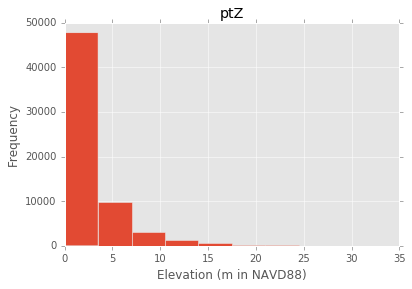

In [57]:
# Print histogram of elevation extracted to points
plots = pts_df.hist('ptZ')

# Subplot Labels
plots[0][0].set_xlabel("Elevation (m in NAVD88)")
plots[0][0].set_ylabel("Frequency")

# Display
plt.show()
plt.close()

### Calculate distances and sort points

__SplitSort__ is a unique numeric identifier of the 5-m points at the study site, sorted by order along shoreline and by distance from oceanside. __SplitSort__ values are populated by sorting the points by __sort_ID__ and __Dist_Seg__ (see below). 

__Dist_Seg__ is the Euclidean distance between the point and the seaward shoreline (__SL_x__, __SL_y__). __Dist_MHWbay__ is the distance between the point and the bayside shoreline and is calculated by subtracting the __Dist_Seg__ value from the __WidthPart__ value of the transect. 

__DistSegDH__, __DistSegDL__, and __DistSegArm__ measure the distance of each 5-m point from the dune crest and dune toe position along a particular transect. They are calculated as the Euclidean distance between the 5-m point and the given feature. 

In [26]:
# Load saved dataframes
pts_df = pd.read_pickle(os.path.join(scratch_dir, 'pts_extractedvalues_presort.pkl'))
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null_prePts.pkl'))

In [27]:
# Calculate DistSeg, Dist_MHWbay, DistSegDH, DistSegDL, DistSegArm, and sort points (SplitSort)
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)
pts_df = fun.prep_points(pts_df, tID_fld, pID_fld, sitevals['MHW'], fill)

# # Aggregate ptZmhw to max and mean and join to transects
pts_df, zmhw = fun.aggregate_z(pts_df, sitevals['MHW'], id_fld=tID_fld, zfld='ptZ', fill=fill)
trans_df = fun.join_columns(trans_df, zmhw) 

# Join transect values to pts
pts_df = fun.join_columns(pts_df, trans_df, tID_fld)

# pID_fld needs to be among the columns
if not pID_fld in pts_df.columns:
    print('Adding {} to columns'.format(pID_fld))
    pts_df.reset_index(drop=False, inplace=True)

# Match field names to those in sorted_pt_flds list
for fld in pts_df.columns:
    if fld not in sorted_pt_flds:
        for i, fldi in enumerate(sorted_pt_flds):
            if fldi.lower() == fld.lower():
                sorted_pt_flds[i] = fld   
                print(fld)
    
# Drop extra fields and sort columns
trans_df.drop(extra_fields, axis=1, inplace=True, errors='ignore')
for i, f in enumerate(sorted_pt_flds):
    for c in pts_df.columns:
        if f.lower() == c.lower():
            sorted_pt_flds[i] = c
pts_df = pts_df.reindex_axis(sorted_pt_flds, axis=1)

# convert projected coordinates to geographic coordinates (lat, lon in NAD83)
pts_df = fun.add_latlon(pts_df, proj_code)

# Save dataframes 
trans_df.to_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

# View random rows from the points DF
pts_df.loc[:,['SplitSort', 'seg_x', 'seg_lon', 'SubType', 'ptZ', 'ptZmhw', 'MHW', 'sort_ID', 'Dist_Seg', 'mean_Zmhw']].sample(10)

Using MHW column in dataframe for MHW adjustment.
Using MHW column in dataframe for MHW adjustment.
Using MHW column in dataframe for MHW adjustment.
Using MHW column in dataframe for MHW adjustment.


,SplitSort,seg_x,seg_lon,SubType,ptZ,ptZmhw,MHW,sort_ID,Dist_Seg,mean_Zmhw
226,226,258617.5738,-71.883395,NaN,1.00,0.71,0.29,9.0,95.000018,0.825294
25367,25367,278384.6527,-71.649306,3333.0,0.00,-0.22,0.22,443.0,302.561412,0.572381
19192,19192,273527.5803,-71.706587,6666.0,4.00,3.78,0.22,340.0,344.999967,4.740000
36200,36200,286905.1499,-71.548222,6666.0,2.60,2.38,0.22,615.0,224.999950,2.270704
51114,51114,294575.0393,-71.458846,6666.0,13.00,12.64,0.36,731.0,503.887969,4.393663
62897,62897,312502.0022,-71.245847,NaN,3.56,3.20,0.36,822.0,165.000011,1.366383
32859,32859,283136.5205,-71.592942,NaN,6.00,5.78,0.22,539.0,185.000038,4.415000
58239,58239,310997.3059,-71.264072,7777.0,3.72,3.36,0.36,789.0,40.000018,2.322417
48533,48533,292064.5355,-71.486236,NaN,5.92,5.70,0.22,715.0,544.999984,4.968790
55459,55459,295322.2820,-71.450221,NaN,0.00,-0.36,0.36,754.0,804.853084,1.061302


### Change number of significant digits

- Elevations: 2 significant digits 
- Lengths: 1 (lidar has 15-30 cm resolution in vertical and 1-m-ish in horizontal I believe)
- UTM coords: 2
- lat longs: 6
- LRR: 2

Would be nice if fill value was always integer (not -99999.0 etc.)

In [36]:
pts_df = pts_df.astype({'Arm_z':'float64', 'Arm_zmhw':'float64'})

In [37]:
# Replace NaNs with fill value
pts_df.fillna(fill, inplace=True) 

# Round fields to given significant digits
fprecision = {# UTM coordinates
            'seg_x':2, 'seg_y':2, 'SL_x':2, 'SL_y':2, 'DL_x':2, 'DL_y':2,
            'DH_x':2, 'DH_y':2, 'DL_snapX':2, 'DL_snapY':2, 'DH_snapX':2, 'DH_snapY':2, 
            'Arm_x':2, 'Arm_y':2,
            # Geographic coordinates
            'seg_lon':6, 'seg_lat':6,
            # Elevations
            'ptZ':2, 'ptZmhw':2, 'DL_z':2, 'DL_zmhw':2, 'DH_z':2, 'DH_zmhw':2, 
            'Arm_z':2, 'Arm_zmhw':2, 'uBH':2, 'mean_Zmhw':2, 'max_Zmhw':2,
            # Lengths
            'Dist_Seg':1, 'Dist_MHWbay':1, 'DistSegDH':1, 'DistSegDL':1, 'DistSegArm':1, 'DistDH':1, 
            'DistDL':1, 'DistArm':1,'Dist2Inlet':1, 'WidthPart':1, 'WidthLand':1, 'WidthFull':1, 'uBW':1,
            # LRR
            'LRR':2,
            # IDs
            'SplitSort':0, 'sort_ID':0, 'TRANSECTID':0, 'DD_ID':0,
            # Other
            'Azimuth':1,'Bslope':4,'ptSlp':4}
pts_df = pts_df.round(fprecision)

# Set GeoSet, SubType, VegDens, VegType fields to int32 dtypes
pts_df = pts_df.astype({'GeoSet':'int32', 'SubType':'int32', 'VegDens':'int32', 'VegType':'int32', 
                        'Construction':'int32', 'Development':'int32', 'Nourishment':'int32', 
                        'sort_ID':'int32', 'DD_ID':'int32', 'TRANSECTID':'int32'})

# Recode
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_fill_ints.pkl'))

# View random rows from the points DF
pts_df.loc[:,['SplitSort', 'sort_ID', 'seg_y', 'VegType', 'ptSlp', 'Dist_Seg', 'max_Zmhw', 'Development', 'TRANSECTID']].sample(10)

,SplitSort,sort_ID,seg_y,VegType,ptSlp,Dist_Seg,max_Zmhw,Development,TRANSECTID
12698,12698,249,4578740.64,55,3.1145,100.0,11.38,333,244
37829,37829,632,4583587.70,55,6.6483,292.1,4.26,333,626
59504,59504,795,4596233.78,99,14.0577,880.0,17.64,333,-99999
38997,38997,651,4583956.03,99,13.7463,275.0,3.86,222,646
16697,16697,320,4579248.07,99,0.2828,155.0,2.78,222,315
18528,18528,333,4579479.18,55,0.0000,150.0,8.78,333,328
9232,9232,209,4579102.84,-99999,0.0000,305.0,4.78,111,206
32409,32409,532,4582805.15,55,7.3539,280.0,7.78,333,527
16942,16942,322,4579251.50,55,0.9055,115.0,3.98,222,317
8295,8295,197,4579010.31,-99999,0.0000,340.0,4.58,111,194


### Recode the values for CSV output and model running

In [38]:
# Recode
pts_df4csv = pts_df.replace({'SubType': {7777:'{1111, 2222}', 1000:'{1111, 3333}'}, 
                              'VegType': {77:'{11, 22}', 88:'{22, 33}', 99:'{33, 44}'},
                              'VegDens': {666: '{111, 222}', 777: '{222, 333}', 
                                          888: '{333, 444}', 999: '{222, 333, 444}'}})

# Save and view sample
pts_df4csv.to_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df.loc[:,['SplitSort', 'sort_ID', 'VegType', 'SubType', 'VegDens', 'GeoType']].sample(10)

,SplitSort,sort_ID,VegType,SubType,VegDens,GeoType
33704,33704,569,99,-99999,444,NaN
1238,1238,42,88,7777,888,NaN
32825,32825,539,77,7777,666,NaN
31772,31772,524,55,6666,555,NaN
34827,34827,591,99,-99999,444,NaN
54878,54878,751,-99999,-99999,-99999,NaN
1913,1913,72,55,6666,555,NaN
12774,12774,250,55,6666,555,NaN
57941,57941,786,55,6666,555,NaN
50228,50228,727,55,6666,555,NaN


In [39]:
# Replace fills with Nulls
pts_df = pts_df.replace(fill, np.nan)
pts_df.to_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

## Quality checking
Look at extracted profiles from around the island. Enter the transect ID within the available range when prompted. Evaluate the plots for consistency among variables. Repeat various times until you can be satisfied that the variables are consistent with each other and appear to represent reality. View areas with inconsistencies in a GIS.

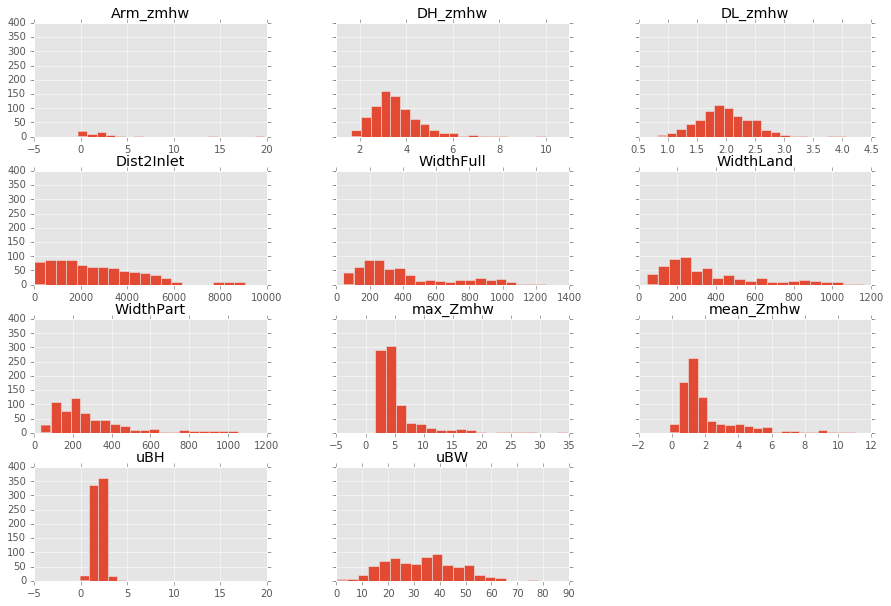

In [31]:
desccols = ['DL_zmhw', 'DH_zmhw', 'Arm_zmhw', 'uBW', 'uBH', 'Dist2Inlet', 
            'WidthPart', 'WidthLand', 'WidthFull', 'mean_Zmhw', 'max_Zmhw']

# Histograms
trans_df.hist(desccols, sharey=True, figsize=[15, 10], bins=20)
plt.show()
plt.close('all')

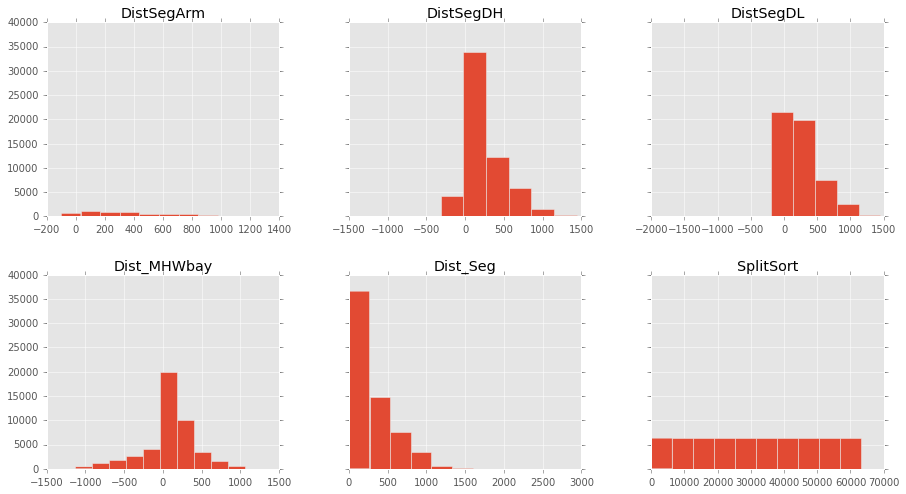

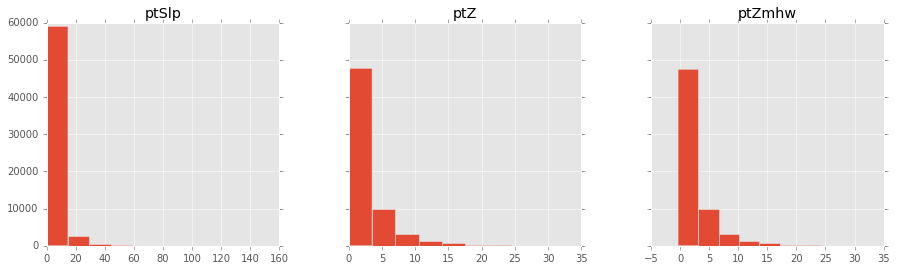

In [32]:
flds_dist = ['SplitSort', 'Dist_Seg', 'Dist_MHWbay', 'DistSegDH', 'DistSegDL', 'DistSegArm']
flds_z = ['ptZmhw', 'ptZ', 'ptSlp']
pts_df.loc[:,flds_dist+flds_z].describe()
pts_df.hist(flds_dist, sharey=True, figsize=[15, 8], layout=(2,3))
pts_df.hist(flds_z, sharey=True, figsize=[15, 4], layout=(1,3))

plt.show()
plt.close('all')

Transect ID ("sort_ID" 1-824):  720


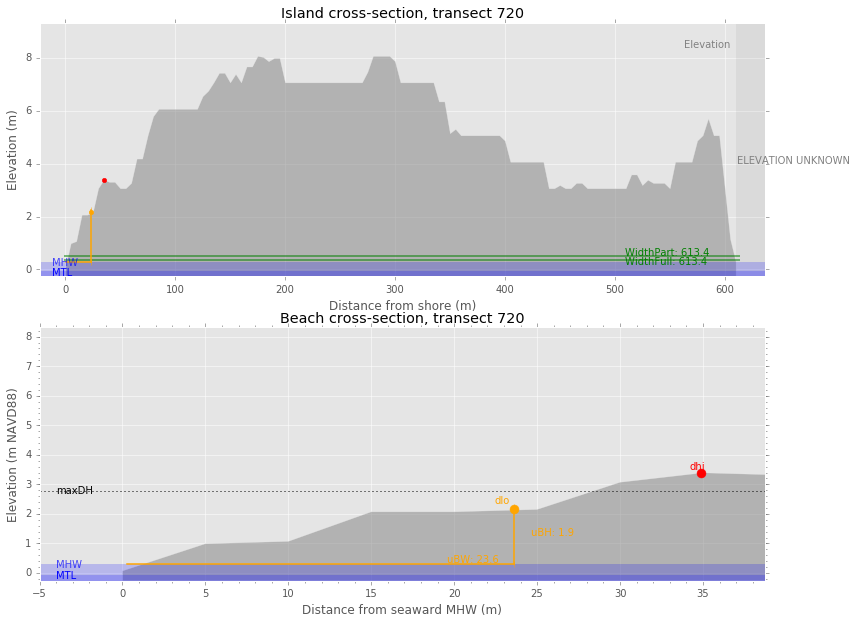

In [33]:
# Prompt for transect identifier (sort_ID) and get all points from that transect.
trans_in = int(input('Transect ID ("sort_ID" {:d}-{:d}): '.format(int(pts_df[tID_fld].head(1)), int(pts_df[tID_fld].tail(1)))))
pts_set = pts_df[pts_df[tID_fld] == trans_in]

# Plot
fig = plt.figure(figsize=(13,10))

# Plot the width of the island.
ax1 = fig.add_subplot(211)
try:
    fun.plot_island_profile(ax1, pts_set, sitevals['MHW'], sitevals['MTL'])
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass

# Zoom in on the upper beach.
ax2 = fig.add_subplot(212)
try:
    fun.plot_beach_profile(ax2, pts_set, sitevals['MHW'], sitevals['MTL'], maxDH)
except TypeError as err:
    print('TypeError: {}'.format(err))
    pass 

# Display
plt.show()
plt.close('all')

### Report field values

In [34]:
# Load dataframe
pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))

In [40]:
xmlfile = os.path.join(scratch_dir, pts_name+'_eainfo.xml')
fun.report_fc_values(pts_df4csv, field_defs, xmlfile)

Number of points in dataset: (63158, 57)

SplitSort______________________________0 | 63157_______________   No fills_________No nulls
seg_x__________________________258351.75 | 312712.79___________   Fills present____No nulls
seg_y_________________________4576411.08 | 4596532.74__________   Fills present____No nulls
seg_lon_______________________-71.886563 | -71.243391__________   Fills present____No nulls
seg_lat________________________41.303685 | 41.49819____________   Fills present____No nulls
Dist_Seg_____________________________0.0 | 2659.2______________   Fills present____No nulls
Dist_MHWbay______________________-1128.7 | 1053.1______________   Fills present____No nulls
DistSegDH________________________-1482.2 | 1437.4______________   Fills present____No nulls
DistSegDL________________________-1852.4 | 1451.0______________   Fills present____No nulls
DistSegArm_________________________-99.3 | 1244.8______________   Fills present____No nulls
ptZ__________________________________0

[]

## Outputs

### Transect-averaged
Output the transect-averaged metrics in the following formats:
- transects, unpopulated except for ID values, as gdb feature class
- transects, unpopulated except for ID values, as shapefile
- populated transects with fill values as gdb feature class
- populated transects with null values as gdb feature class
- populated transects with fill values as shapefile
- raster of beach width (__uBW__) by transect

In [43]:
# Load the dataframe
trans_df = pd.read_pickle(os.path.join(scratch_dir, trans_name+'_null.pkl'))

#### Vector format

In [44]:
# Create transect file with only ID values and geometry to publish.
for i, f in enumerate(trans_flds):
    for c in trans_df.columns:
        if f.lower() == c.lower():
            trans_flds[i] = c
            
trans_4pub = fwa.JoinDFtoFC(trans_df.loc[:,trans_flds], extendedTrans, tID_fld, out_fc=sitevals['code']+'_trans')
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_4pub, scratch_dir, sitevals['code']+'_trans.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created ri_trans from input dataframe and extTrans file.
OUTPUT: ri_trans.shp in specified scratch_dir.


In [45]:
trans_4pubdf = fwa.FCtoDF(trans_4pub)
xmlfile = os.path.join(scratch_dir, trans_4pub + '_eainfo.xml')
trans_df_extra_flds = fun.report_fc_values(trans_4pubdf, field_defs, xmlfile)

...converting feature class to array...
...converting array to dataframe...
Number of points in dataset: (824, 8)

Shape............... nan
sort_ID________________________________1 | 824_________________   No fills_________No nulls
Shape_Length__________1296.9111451862304 | 3590.64261346657____   No fills_________No nulls
TRANSECTID___________________________1.0 | 1966.0______________   No fills_______Nulls present
TransOrder___________________________1.0 | 947.0_______________   No fills_______Nulls present
DD_ID______________________________50001 | 50824_______________   No fills_________No nulls
MHW_________________________________0.22 | 0.36________________   No fills_________No nulls



In [46]:
# Delete extra fields from points feature class
if len(trans_df_extra_flds) > 0:
    for fld in trans_df_extra_flds:
        try:
            arcpy.DeleteField_management(trans_4pub, fld)
            print('Deleted field "{}"'.format(fld))
        except:
            print('WARNING: Failed to delete field "{}"'.format(fld))
            pass

In [47]:
# Create transect FC with fill values - Join values from trans_df to the transect FC as a new file.
trans_fc = fwa.JoinDFtoFC_2(trans_df, extendedTrans, tID_fld, out_fc=trans_name+'_fill')

# Create transect FC with null values
fwa.CopyFCandReplaceValues(trans_fc, fill, None, out_fc=trans_name+'_null', out_dir=home)

# Save final transect SHP with fill values
out_shp = arcpy.FeatureClassToFeatureClass_conversion(trans_fc, scratch_dir, trans_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_shp))))

Created ri14_trans_fill from input dataframe and extTrans file.
OUTPUT: ri14_trans_null
OUTPUT: ri14_trans_shp.shp in specified scratch_dir.


#### Raster - beach width
It may be necessary to close any Arc sessions you have open.

In [48]:
# Create a template raster corresponding to the transects. 
if not arcpy.Exists(rst_transID):
    print("{} was not found so we will create the base raster.".format(os.path.basename(rst_transID)))
    outEucAll = arcpy.sa.EucAllocation(extTrans_tidy, maximum_distance=50, cell_size=cell_size, source_field=tID_fld)
    outEucAll.save(os.path.basename(rst_transID))

# Create raster of uBW values by joining trans_df to the template raster.
out_rst = fwa.JoinDFtoRaster(trans_df, os.path.basename(rst_transID), bw_rst, fill, tID_fld, 'uBW')

OUTPUT: ri14_ubw. Field "Value" is ID and "uBW" is beachwidth.


### 5-m points

Output the point metrics in the following formats:
- tabular, in CSV
- populated points with fill values as gdb feature class
- populated points with null values as gdb feature class
- populated points with fill values as shapefile

In [49]:
# Load the saved dataframes
pts_df4csv = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_csv.pkl'))
pts_df = pd.read_pickle(os.path.join(scratch_dir, pts_name+'_null.pkl'))

#### Tabular format

In [50]:
# Save CSV in scratch_dir
csv_fname = os.path.join(scratch_dir, pts_name +'.csv')
pts_df4csv.to_csv(csv_fname, na_rep=fill, index=False)

sz_mb = os.stat(csv_fname).st_size/(1024.0 * 1024.0)
print("\nOUTPUT: {} (size: {:.2f} MB) in specified scratch_dir.".format(os.path.basename(csv_fname), sz_mb))


OUTPUT: ri14_pts.csv (size: 24.22 MB) in specified scratch_dir.


#### Vector format

In [51]:
# Convert pts_df to FC - automatically converts NaNs to fills (default fill is -99999)
pts_fc = fwa.DFtoFC_large(pts_df, out_fc=os.path.join(arcpy.env.workspace, pts_name+'_fill'), 
                          spatial_ref=utmSR, df_id=pID_fld, xy=["seg_x", "seg_y"])

# Save final FCs with null values
fwa.CopyFCandReplaceValues(pts_fc, fill, None, out_fc=pts_name+'_null', out_dir=home)

# Save final points as SHP with fill values
out_pts_shp = arcpy.FeatureClassToFeatureClass_conversion(pts_fc, scratch_dir, pts_name+'_shp.shp')
print("OUTPUT: {} in specified scratch_dir.".format(os.path.basename(str(out_pts_shp))))

Converting points DF to FC...
... converting dataframe to array... 
... converting array to feature class... 

OUTPUT: ri14_pts_fill
Duration: 0:6:48.8 seconds
OUTPUT: ri14_pts_null
OUTPUT: ri14_pts_shp.shp in specified scratch_dir.
